# Optimization hands-on session: the Heat Equation

To test the different optimization techniques, we will try to optimize an explicit finite different scheme (with a Jacobi iteration method) to solve the Heat equation:

\begin{equation*}\partial_t \phi = \alpha \left[\partial^2_{x^2}\phi + \partial^2_{y^2} \phi\right], \text{ for } x \in [0, L_x], \quad y \in [0, L_y], \quad t \geq 0.\end{equation*}

We will use a 3-points central difference method, with a 2nd-order accuracy; it means that $\phi_{i,j}$ is updated at time $t = t_{n+1} = (n+1)\Delta t$ following:

\begin{eqnarray*}\phi_{i,j}^{n+1} & = & \phi_{i,j}^{n} + \alpha\frac{\Delta t}{\Delta x \Delta y}\left[\left(\phi_{i+1,j}^n - 2 \phi_{i,j}^n + \phi_{i-1,j}^n\right) +  \left(\phi_{i,j+1}^n - 2 \phi_{i,j}^n + \phi_{i,j-1}^n\right)\right] \\
 & = & R_2 \phi_{i,j}^n + R\left[\phi_{i+1,j}^n + \phi_{i-1,j}^n + \phi_{i,j+1}^n + \phi_{i,j-1}^n\right],\end{eqnarray*}
 
 with $R = \alpha \Delta t/\Delta x/\Delta y$, and $R_2 = 1 - 4R$. For the sake of simplicity, we will consider $\alpha = L_x = L_y = 1$.

## Python version

First, let's try a normal Python version to see how it is implemented and what it returns:

In [3]:
%matplotlib inline

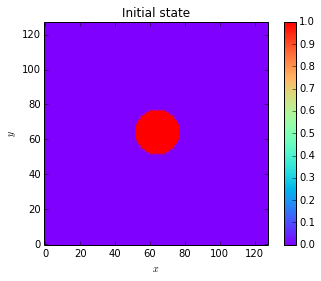

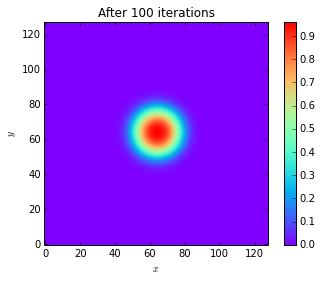

In [4]:
import numpy as np
import pylab as pl

# Jacobi function
def jacobi(a, nxi, nyi):
    for i in xrange(1,nxi-1):
        for j in xrange(1,nyi-1):
            anew[i,j] = 0.5*a[i,j] + 0.125*(a[i-1,j] + a[i+1,j] \
                                   + a[i,j-1] + a[i,j+1])
    return anew

# Solver: iterate and call the Jacobi function
def solveHeat(a, anew, nxi, nyi, niter):
    i = 1
    while (i < niter):
        anew = jacobi(a, nxi, nyi)
        a = anew.copy()
        i += 1
    return anew

# Problem initialization: hot disc in a cold medium
def initProblem(a, nxi, nyi):
    for i in xrange(nxi):
        for j in xrange(nyi):
            indx = (i - nxi/2)/(nxi/10.)
            indy = (j - nyi/2)/(nyi/10.)
            if (indx**2 + indy**2) <= 1:
                a[i,j] = 1.
    return a

def plotResult(a, title='', *args, **kwargs):
    fig = pl.figure()
    pl.imshow(a, origin='lower', cmap='rainbow')
    pl.title(title)
    pl.xlabel(r'$x$')
    pl.ylabel(r'$y$')
    pl.colorbar()
    return fig
     
# Parameters of the problem
niter = 100
nx = 128
ny = 128
a = np.zeros((nx,ny))
a = initProblem(a, nx, ny)
anew = a.copy()

# Plot and solve the problem
fig1 = plotResult(a, 'Initial state')
anew = solveHeat(a, anew, nx, ny, niter)
fig2 = plotResult(anew, 'After %d iterations' %niter)

Allright, and if we time it:

In [16]:
niter = 10
nx = 128
ny = 128
a = np.zeros((nx,ny))
a = initProblem(a, nx, ny)
anew = a.copy()
pyversion = %timeit -o solveHeat(a, anew, nx, ny, niter)
times = []; labels = []
times.append(pyversion.best)
labels.append('Python')

1 loops, best of 3: 769 ms per loop


Can we do better?

## Cython version

In [6]:
%load_ext cythonmagic

The Cython magic has been moved to the Cython package, hence 
`%load_ext cythonmagic` is deprecated; please use `%load_ext Cython` instead.

Though, because I am nice, I'll still try to load it for you this time.


In [7]:
%%cython
cimport numpy as cnp
import numpy as np
import cython

@cython.wraparound(False)
@cython.boundscheck(False)
cdef cnp.ndarray[cnp.float64_t, ndim=2] jacobiCython(cnp.ndarray[cnp.float64_t, ndim=2] a, int nxi, int nyi):
    cdef:
        int i, j
        cnp.ndarray[cnp.float64_t, ndim=2] anew = cnp.ndarray(shape=(nxi,nyi))
    for i in xrange(1,nxi-1):
        for j in xrange(1,nyi-1):
            anew[i,j] = 0.5*a[i,j] + 0.125*(a[i-1,j] + a[i+1,j] \
                                   + a[i,j-1] + a[i,j+1])
    return anew

@cython.wraparound(False)
@cython.boundscheck(False)
def solveHeatCython(cnp.ndarray[cnp.float64_t, ndim=2] a, cnp.ndarray[cnp.float64_t, ndim=2] anew, int nxi, int nyi, int niter):
    cdef i = 1
    while (i < niter):
        anew = jacobiCython(a, nxi, nyi)
        a = anew.copy()
        i += 1
    return anew

In [17]:
a = np.zeros((nx,ny))
a = initProblem(a, nx, ny)
anew = a.copy()
cyversion = %timeit -o solveHeatCython(a, anew, nx, ny, niter)
times.append(cyversion.best)
labels.append('Cython')

1000 loops, best of 3: 1.63 ms per loop


## F2py version

In [9]:
%%file heat.f90
module heat
contains
  function jacobiFortran(a, nxi, nyi) result(anew)
    implicit none

    integer, intent(in) :: nxi, nyi
    real(8), dimension(nxi, nyi), intent(in)  :: a
    real(8), dimension(nxi, nyi) :: anew
    integer :: i, j

    do j = 2, nyi-1
       do i = 2, nxi-1
          anew(i,j) = + 0.5d0*a(i,j) + 0.125d0*(a(i-1,j) + a(i+1,j) &
                                   & + a(i,j-1) + a(i,j+1))
       enddo
    enddo

  end function jacobiFortran

  subroutine solveHeatFortran(a, anew, nxi, nyi, niter)
    implicit none

    integer, intent(in) :: nxi, nyi, niter
    real(8), dimension(nxi, nyi), intent(inout) :: a
    real(8), dimension(nxi, nyi), intent(inout) :: anew
    integer :: i
  
    i = 0
    do while (i < niter)
       anew = jacobiFortran(a, nxi, nyi)
       a = anew
       i = i + 1
    enddo

  end subroutine solveHeatFortran
end module heat

Writing heat.f90


In [10]:
!f2py -c -m heat heat.f90

running build
running config_cc
unifing config_cc, config, build_clib, build_ext, build commands --compiler options
running config_fc
unifing config_fc, config, build_clib, build_ext, build commands --fcompiler options
running build_src
build_src
building extension "heat" sources
f2py options: []
f2py:> /tmp/tmp0LKEZ6/src.linux-x86_64-2.7/heatmodule.c
creating /tmp/tmp0LKEZ6/src.linux-x86_64-2.7
Reading fortran codes...
	Reading file 'heat.f90' (format:free)
Post-processing...
	Block: heat
			Block: heat
				Block: jacobifortran
appenddecl: "dimension" not implemented.
				Block: solveheatfortran
Post-processing (stage 2)...
	Block: heat
		Block: unknown_interface
			Block: heat
				Block: jacobifortran
				Block: solveheatfortran
Building modules...
	Building module "heat"...
		Constructing F90 module support for "heat"...
		Creating wrapper for Fortran function "jacobifortran"("jacobifortran")...
			Constructing wrapper function "heat.jacobifortran"...
			  anew = jacobifortran(a,[nx

In [18]:
from heat import heat

a = np.zeros((nx,ny))
a = initProblem(a, nx, ny)
aF   = a.copy(order='F')
anew = aF.copy(order='F')
fpversion = %timeit -o heat.solveheatfortran(aF, anew, niter)
times.append(fpversion.best)
labels.append('F2Py')

1000 loops, best of 3: 1.41 ms per loop


## Numba version

In this case, Numba is faster if `anew` is not only returned by the function, but also pass as argument:

In [12]:
from numba import autojit

@autojit
def jacobiNumba(a, anew, nxi, nyi):
    for i in xrange(1,nxi-1):
        for j in xrange(1,nyi-1):
            anew[i,j] = 0.5*a[i,j] + 0.125*(a[i-1,j] + a[i+1,j] \
                                   + a[i,j-1] + a[i,j+1])
    return anew

@autojit
def solveHeatNumba(a, anew, nxi, nyi, niter):
    i = 1
    while (i < niter):
        anew = jacobiNumba(a, anew, nxi, nyi)
        a = anew.copy()
        i += 1
    return anew

In [19]:
a = np.zeros((nx,ny))
a = initProblem(a, nx, ny)
anew = a.copy()
nbversion = %timeit -o solveHeatNumba(a, anew, nx, ny, niter)
times.append(nbversion.best)
labels.append('Numba')

1000 loops, best of 3: 1.29 ms per loop


## NumPy version

Thanks to Karl, here is a pure NumPy version. As you can see, the performances are very similar to what you'd get from Cython, F2Py or Numba!

In [14]:
def jacobiNumPy(a):
    """ ix,iy should be output from meshgrid() """
    a_ijp1 = a[1:-2,1:-2]
    a_ij   = a[1:-1,1:-1]
    a_im1j = a[0:-2,1:-1]
    a_ip1j = a[2:,1:-1]
    a_ijm1 = a[1:-1,0:-2]
    a_ijp1 = a[1:-1,2:]
    
    a[1:-1,1:-1] = 0.5*a_ij + 0.125*( a_im1j + a_ip1j + a_ijm1 + a_ijp1 ) 
    return a

# Solver: iterate and call the Jacobi function
def solveHeatNumPy(a, anew, nxi, nyi, niter):
    i = 1
    while (i < niter):
        anew = jacobiNumPy(a)
        #a = anew.copy()
        i += 1
    return anew

In [20]:
a = np.zeros((nx,ny))
a = initProblem(a, nx, ny)
anew = a.copy()
npversion = %timeit -o solveHeatNumPy(a, anew, nx, ny, niter)
times.append(npversion.best)
labels.append('NumPy')

100 loops, best of 3: 4.62 ms per loop


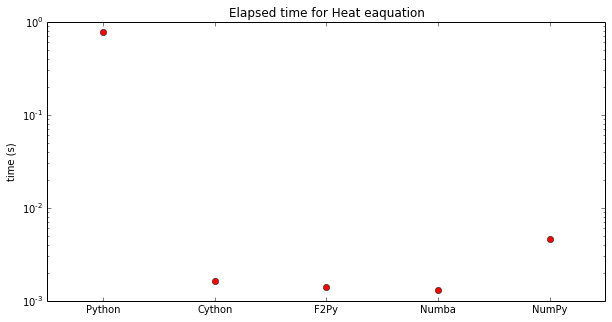

In [22]:
def plotElpTime(times, labels, *args, **kwargs):
    fig = pl.figure(figsize=(len(times)*2,5))
    pl.title(r'Elapsed time for Heat eaquation')
    pl.ylabel('time (s)')
    pl.xticks(range(len(times)), labels)
    pl.xlim(-0.5, len(times)-0.5)
    pl.semilogy(times, 'ro')
    return fig
 
fig = plotElpTime(times, labels)

# Concurrent & parallel computing hands-on session: Monte Carlo Pi

We will compute the approximate value of $\pi$ with a Monte Carlo integration algorithm. Each point $(x,y)$ in a list of random points within a "unit" square is evaluated using the function:

$$f(x,y) = (x^2 + y^2 < 1) \quad ? \quad 1 \quad : \quad 0$$

The points are then summed. The approximate value of $\pi$ can then be calculated by multiplying four times the volume of the square with the mean value for $f(x,y)$.

The code itself is quite simple, and the algorithm is *embarassingly* parallel because each $f(x,y)$ calculation can be performed independently. Besides, the algorithm uses a sum reduction, which makes it interesting.

## Python version

In [3]:
import numpy as np

def compPi(nelmt=int(1e6)):
    # Initialize points coordinates (x,y)
    x = np.random.random(nelmt)
    y = np.random.random(nelmt)
    temp = np.zeros(nelmt)
    # Evaluation of each point with f 
    for i in xrange(nelmt):
        radSq = x[i]*x[i] + y[i]*y[i]
        temp[i] = 1 if (radSq < 1) else 0
    
    sumA = 0.
    for i in xrange(nelmt):
        sumA += temp[i]

    return 4*sumA/nelmt

%timeit compPi()

1 loops, best of 3: 1.67 s per loop


## `multiprocessing` version

For the multiprocessing version, the simplest thing to do is to distribute evenly the work among the processes (for example using a pool):

In [4]:
import multiprocessing as mp

def piPool(nelmt=int(1e6)):
    # Get number of CPU available and define the number of processes
    nproc  = mp.cpu_count()
    # Create pool
    pool   = mp.Pool(processes=nproc)
    # Distribute the work among processes
    result = pool.map(compPi, [nelmt/nproc for i in xrange(nproc)])
    return sum(result)/nproc

%timeit piPool()

1 loops, best of 3: 632 ms per loop


## `mpi4py` version

The same can be done with MPI; the main trick is to not forget to reduce the result:

In [39]:
%%file piparallel.py
#!/usr/bin/env python
import os
from mpi4py import MPI
import numpy as np

def compPi(nelmt=int(1e6)):
    x = np.random.random(nelmt)
    y = np.random.random(nelmt)
    temp = np.zeros(nelmt)
    for i in xrange(nelmt):
        radSq = x[i]*x[i] + y[i]*y[i]
        temp[i] = 1 if (radSq < 1) else 0
    
    sumA = 0.
    for i in xrange(nelmt):
        sumA += temp[i]

    return 4*sumA/nelmt

def piMPI(nelmt=int(1e6)):
    # Communicator initalization
    comm = MPI.COMM_WORLD
    size = comm.Get_size()
    rank = comm.Get_rank()
    
    t1 = MPI.Wtime()
    # Compute pi for a subset of elements for each process
    piLoc = compPi(nelmt/size)
    # perform a sum reduction on process 0
    pi = comm.reduce(piLoc, op=MPI.SUM, root=0)
    if rank == 0:
        pi = pi/size
    # broadcast the result to the other processes
    pi = comm.bcast(pi, root=0)
    t2 = MPI.Wtime()
    if rank == 0: print("Elapsed time: %9.8f s" %(t2 - t1))
    return pi

if __name__ == '__main__':
    pi = piMPI()

Overwriting piparallel.py


In [8]:
%%bash
chmod +x piparallel.py
mpirun -np 4 ./piparallel.py

Elapsed time: 0.56077099 s
